In [72]:
import numpy as np  # Import numpy for numerical operations
import matplotlib.pyplot as plt  # Import matplotlib for creating plots
import pandas as pd  # Import pandas for handling tabular data
import seaborn as sns  # Import seaborn for advanced data visualization
from sklearn.model_selection import train_test_split  # Import function to split data into training and testing sets
from sklearn.linear_model import LogisticRegression  # Import logistic regression model
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis  # Import linear discriminant analysis
from sklearn.neighbors import KNeighborsClassifier  # Import k-nearest neighbors classifier
from sklearn.naive_bayes import GaussianNB  # Import Gaussian Naive Bayes classifier
from sklearn.metrics import (  # Import performance evaluation metrics
    accuracy_score,  # To calculate accuracy
    confusion_matrix,  # To compute confusion matrices
    roc_curve,  # To generate ROC curves
    roc_auc_score  # To calculate the area under the ROC curve
)
from sklearn.preprocessing import StandardScaler  # Import scaler for standardizing features
from sklearn.decomposition import PCA  # Import PCA for dimensionality reduction


# Part 1: Analyzing the Base

### Part 1, Question 1

1.	Using information available on the INDEC website, briefly explain how unemployed people are identified.

### Part 1, Question 2a

2a. Eliminate all observations that do not correspond to the agglomerations of the Autonomous City of Buenos Aires (CABA) or the Parties of Greater Buenos Aires, and merge both quarters into a single base.


In [2]:
# Load the 2004 data from a Stata (.dta) file into a pandas DataFrame
T1_2004 = pd.read_stata('Individual_t104.dta')

# Load the 2024 data from an Excel (.xlsx) file into a pandas DataFrame
T1_2024 = pd.read_excel('usu_individual_T124.xlsx')


In [3]:
''' Gran Buenos Aires Codigo de Region = 1
    Partidos del GBA Codigo de Aglomerado = 33
    It looks like pandas extracts that for you from the dta code.'''

''' On inspection the stata data from 2004 automatically converts the codes into a human-readable format.
    There is no such translation for the 2024 data'''

# Print column names, unique regions, and agglomeration codes in the 2004 data
print(T1_2004.columns, T1_2004.region.unique(), T1_2004.aglomerado.unique(), '\n')

# Print column names, unique regions, and agglomeration codes in the 2024 data
print(T1_2024.columns, T1_2024.REGION.unique(), '\n', T1_2024.AGLOMERADO.unique())


Index(['CODUSU', 'nro_hogar', 'componente', 'h15', 'ano4', 'trimestre',
       'region', 'mas_500', 'aglomerado', 'pondera',
       ...
       'deccfr', 'ideccfr', 'rdeccfr', 'gdeccfr', 'pdeccfr', 'adeccfr',
       'pj1_1', 'pj2_1', 'pj3_1', 'idimpp'],
      dtype='object', length=176) ['Gran Buenos Aires', 'NOA', 'NEA', 'Cuyo', 'Pampeana', 'Patagónica']
Categories (6, object): ['Gran Buenos Aires' < 'NOA' < 'NEA' < 'Cuyo' < 'Pampeana' < 'Patagónica'] ['Ciudad de Buenos Aires', 'Partidos del GBA', 'Santiago del Estero - La Banda', 'Jujuy - Palpalá', 'Gran Catamarca', ..., 'Río Cuarto', 'Comodoro Rivadavia - Rada Tilly', 'Neuquén - Plottier', 'Río Gallegos', 'Ushuaia - Río Grande']
Length: 29
Categories (29, object): ['Gran La Plata' < 'Bahía Blanca - Cerri' < 'Gran Rosario' < 'Gran Santa Fe' ... 'Ciudad de Buenos Aires' < 'Partidos del GBA' < 'Mar del Plata - Batán' < 'Río Cuarto'] 

Index(['CODUSU', 'ANO4', 'TRIMESTRE', 'NRO_HOGAR', 'COMPONENTE', 'H15',
       'REGION', 'MAS_500', 'AG

In [4]:
''' The problem here is that while the human readable information is convenient
    for us, it's not helpful in the analysis later, because the xlsx derived data
    comes over as code.  Instead of conversion on a case by case basis, we'll just
    use the stata key-value pairs and map the labels back to the codes'''

def convert_labels_to_codes(df, stata_file_path):
    """
    Converts human-readable labels in a Stata DataFrame to numerical codes using
    the value labels from the Stata file.

    Parameters:
    df (pd.DataFrame): DataFrame with human-readable labels.
    stata_file_path (str): Path to the original Stata file.

    Returns:
    pd.DataFrame: DataFrame with labels replaced by their corresponding numerical codes.
    """
    # Access value labels in the Stata file
    with pd.io.stata.StataReader(stata_file_path) as reader:  # Open the Stata file in read mode
        value_labels = reader.value_labels()  # Extract value labels (human-readable to code mapping)

    # Loop through each column in the DataFrame
    for column in df.columns:
        if column in value_labels:  # Check if the column has associated value labels
            label_mapping = {v: k for k, v in value_labels[column].items()}  # Reverse mapping (label -> code)
            
            # Check if the column is a categorical type
            if pd.api.types.is_categorical_dtype(df[column]):
                # Rename categories in the column using the label-to-code mapping
                df[column] = df[column].cat.rename_categories(label_mapping)
            else:
                # Map values directly for non-categorical columns and fill any missing mappings
                df[column] = df[column].map(label_mapping).fillna(df[column])

    return df  # Return the modified DataFrame

# Apply the conversion function to the 2004 dataset
T1_2004 = convert_labels_to_codes(T1_2004, 'Individual_t104.dta')


In [6]:
T1_2004

,CODUSU,nro_hogar,componente,h15,ano4,trimestre,region,mas_500,aglomerado,pondera,...,deccfr,ideccfr,rdeccfr,gdeccfr,pdeccfr,adeccfr,pj1_1,pj2_1,pj3_1,idimpp
0,125098,1.0,1.0,1.0,2004.0,1,1,S,32,1299.0,...,07,,06,06,,04,0.0,0.0,0.0,00000
1,125397,1.0,1.0,1.0,2004.0,1,1,S,32,2018.0,...,00,,00,00,,00,0.0,0.0,0.0,00000
2,125515,1.0,1.0,1.0,2004.0,1,1,S,32,1486.0,...,07,,07,07,,05,0.0,0.0,0.0,00020
3,125558,1.0,1.0,1.0,2004.0,1,1,S,32,1674.0,...,08,,08,08,,06,0.0,0.0,0.0,00000
4,125558,1.0,2.0,1.0,2004.0,1,1,S,32,1674.0,...,08,,08,08,,06,0.0,0.0,0.0,00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45284,285733,1.0,1.0,1.0,2004.0,1,44,N,31,123.0,...,09,09,08,,09,07,0.0,0.0,0.0,00000
45285,285733,1.0,2.0,1.0,2004.0,1,44,N,31,123.0,...,09,09,08,,09,07,0.0,0.0,0.0,00000
45286,285733,1.0,3.0,1.0,2004.0,1,44,N,31,123.0,...,09,09,08,,09,07,0.0,0.0,0.0,00000
45287,285733,1.0,4.0,0.0,2004.0,1,44,N,31,123.0,...,09,09,08,,09,07,0.0,0.0,0.0,00000


In [7]:
''' To merge the data into a single dataframe as per this question we have two steps:
    1.  Select only the rows of data where the region and aglomerado match our criteria
    2.  Merging the dataframes where the column names don't match will yield none/NaN values
        in the rows from the years that don't have them.  We need to filter those columns out
        before we merge; there's no point in keeping those since we cannot compare NaN's.
        If we want to keep that data, there's already a copy - the original dataframe for that year'''

''' For real world use, you would also want to convert the data in the new dataframe to the same format
    2004 is more human readable than 2024.  This is complicated by the fact that census data codes and
    categories often change over time.  However, that is not being asked for in this homework'''


''' Selecting the rows where the region or aglomerado match our criteria'''
def filter_and_select_rows(df, filters):
    """
    Filters rows in a DataFrame based on column-value conditions using OR logic.

    Parameters:
    df (pd.DataFrame): DataFrame to filter.
    filters (dict): Dictionary specifying column-value pairs for filtering.

    Returns:
    pd.DataFrame: Filtered DataFrame containing rows that match any filter condition.
    """
    filter_condition = False  # Initialize the filter condition (logical OR of all conditions)

    # Loop through each column-value pair in the filters dictionary
    for column, value in filters.items():
        filter_condition |= (df[column] == value)  # Add condition for rows where column equals the value

    return df[filter_condition]  # Apply the filter and return the resulting DataFrame

# Filter 2004 data for region 1 or agglomeration 33
filtered_2004 = filter_and_select_rows(T1_2004, {'region': 1, 'aglomerado': 33})

# Filter 2024 data for REGION 1 or AGLOMERADO 33
filtered_2024 = filter_and_select_rows(T1_2024, {'REGION': 1, 'AGLOMERADO': 33})


In [8]:
''' The stata column names from 2004 are in lower case, and those from 2024 are in upper case.
    Python is case-sensitive, and will treat the lower case and upper case versions of the column
    names as DIFFERENT COLUMNS - even though we know they are the same, the computer thinks they are different,
    because each character has a different assigned numerical byte sequence; e.g. S and s are not numerically the same
    for the computer. So we'll convert the column names to the same format.  The line of code below sets the column 
    names in 2004 to the upper case version, to match those from 2024. That lets us merge the now-matched column names properly'''

filtered_2004.columns = filtered_2004.columns.str.upper()

In [9]:
''' Now we need to compare the column names to see if there are columns in 2004 that are not in 2024 and vice-versa.
    There are several ways to do this, but the easiest is to grab the column names as an unordered set, then use the
    subtraction operator for set comparison, as per the below.  This lets us drop any columns they do not have in common.'''

def compare_columns(df1, df2):
    """
    Compare column names from two DataFrames and find columns that are not in both.

    Parameters:
    df1 (pd.DataFrame): The first DataFrame.
    df2 (pd.DataFrame): The second DataFrame.

    Returns:
    tuple: Two lists of column names:
           - Columns only in df1.
           - Columns only in df2.
    """
    # Get the column names as sets
    columns_df1 = set(df1.columns)
    columns_df2 = set(df2.columns)
    
    # Find differences
    only_in_df1 = list(columns_df1 - columns_df2)  # Columns in df1 but not in df2
    only_in_df2 = list(columns_df2 - columns_df1)  # Columns in df2 but not in df1

    return only_in_df1, only_in_df2


In [10]:
''' This returns what is in each dataframe that IS NOT in the other one'''
drop_2004, drop_2024 = compare_columns(filtered_2004, filtered_2024)
print(drop_2004, drop_2024)

''' Now we'll drop the columns from their respective dataframes.
    Notice - we're passing LISTS to the Pandas method here.
    Pandas does this a lot - you pass the lists of things, not
    the thing - so if you're doing one column, it has to be a 
    list with just the one column in it...'''
dropped_2004 = filtered_2004.drop(columns=drop_2004)
dropped_2024 = filtered_2024.drop(columns=drop_2024)

''' Just as a check, we'll print the number of columns in each dataframe - they should match now...
    And as we can see they are both 172'''

print(len(dropped_2004.columns), len(dropped_2024.columns))

['PJ3_1', 'PJ2_1', 'PJ1_1', 'IDIMPP'] ['IMPUTA', 'PONDIH', 'PONDIIO', 'PONDII', 'CH05']
172 172


In [11]:
''' And now we concatenate the dataframes on the vertical axis, stacking the rows on top of each other, since the 
    columns match.  We ignore the index so it will assign a new set of index numbers and there will be no
    index number conflicts'''

df_2004_24 = pd.concat([dropped_2004, dropped_2024], ignore_index=True, axis = 0)



### Part 1, Question 2b

2b.	If there are observations with values that do not make sense, discard them (for example, negative income and age). Explain the decisions made.

In [12]:
df_2004_24.isna().sum()

CODUSU           0
NRO_HOGAR        0
COMPONENTE       0
H15              0
ANO4             0
              ... 
IDECCFR       7051
RDECCFR          0
GDECCFR          0
PDECCFR       7051
ADECCFR          0
Length: 172, dtype: int64

In [13]:
''' The above examination of the NaNs shows that discarding all observations (rows) containing a NaN would make the data useless - about
    half the data would go missing.  These NaN's however, appear in only a subset of the columns and are consistent in number, 
    suggesting that the data simply was uncollected in those columns, over the same observations, for whatever reason, and numbers
    in the thousands.  Given this I would consider the data in those columns to be unreliable, and simply eliminate them, unless I 
    needed that information specifically, in which case I would turn to ways to potentially infer their values.  
    
    *** How the data is cleaned depends on what you want to do with it.  I note that these columns containing all the NaN's are 
    not needed to answer the homework questions and suitable to be dropped on that basis.  For other purposes, it might be necessary to 
    go through the database and clean it on a more discrete basis.
    
    The function below returns a dataframe where the columns are dropped based on a NaN threshold entered in the arguments'''

def drop_columns_with_nans(df, max_nans):
    """
    Drops columns with more than a specified threshold of NaN values.

    Parameters:
    df (pd.DataFrame): DataFrame to clean.
    max_nans (int): Maximum allowed NaN values per column.

    Returns:
    pd.DataFrame: DataFrame with columns exceeding the threshold dropped.
    """
    # Count the number of NaNs in each column
    nan_counts = df.isna().sum()

    # Identify columns with NaNs exceeding the specified threshold
    columns_to_drop = nan_counts[nan_counts > max_nans].index

    # Drop the identified columns from the DataFrame
    return df.drop(columns=columns_to_drop)

# Drop columns with more than 1000 NaN values from the combined dataset
nan_dropped_2004_24 = drop_columns_with_nans(df_2004_24, 1000)

# Print the updated number of columns after dropping
print(len(nan_dropped_2004_24.columns))



71


In [14]:
def count_nans_per_column(df):
    """
    Counts the number of NaN values in each column of a DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame to analyze.

    Returns:
    pd.Series: Series with column names as index and NaN counts as values.
    """
    # Count NaN values for each column and return the result
    nan_counts = df.isna().sum()
    return nan_counts[nan_counts > 0]

# Check for remaining columns with NaN values
count_nans_per_column(nan_dropped_2004_24)


P47T    41
dtype: int64

In [15]:
'''Now we'll run a search for columns containing negative numbers to see if they make sense - can only use it on numeric columns...'''

def find_columns_with_negatives(df):
    """
    Identifies numeric columns in a DataFrame that contain negative values.

    Parameters:
    df (pd.DataFrame): DataFrame to analyze.

    Returns:
    list: Names of columns containing negative values.
    """
    # Select numeric columns only
    numeric_df = df.select_dtypes(include=['number'])

    # Check for negative values and return column names
    return [col for col in numeric_df.columns if (numeric_df[col] < 0).any()]

def count_negatives_per_column(df):
    """
    Counts the number of negative values in each numeric column.

    Parameters:
    df (pd.DataFrame): DataFrame to analyze.

    Returns:
    pd.Series: Series with column names as index and count of negative values as values.
    """
    # Select numeric columns only
    numeric_df = df.select_dtypes(include=['number'])

    # Count the number of negative values per column
    return (numeric_df < 0).sum()

In [16]:
''' A review of the columns in which there are negatives shows that these are income data.
    filling the them with the median income information makes sense; the mean is often
    skewed in income data because of large outliers.  We will do the same with the NaNs
    The function for this is in the next cell, below.'''
count_negatives_per_column(nan_dropped_2004_24)

NRO_HOGAR        0
COMPONENTE       0
H15              0
ANO4             0
TRIMESTRE        0
REGION           0
AGLOMERADO       0
PONDERA          0
CH03             0
CH04             0
CH06           182
CH07             0
CH08             0
CH09             0
CH10             0
CH11             0
CH12             0
CH13             0
CH15             0
CH16             0
NIVEL_ED         0
ESTADO           0
CAT_OCUP         0
CAT_INAC         0
PP02C1           0
PP02C2           0
PP02C3           0
PP02C4           0
PP02C5           0
PP02C6           0
PP02C7           0
PP02C8           0
PP02E            0
PP02H            0
PP02I            0
P21            946
TOT_P12        104
P47T          1292
V2_M           174
V3_M             2
V4_M             0
V5_M            42
V8_M            18
V9_M             3
V10_M           40
V11_M           14
V12_M           52
V18_M            2
V19_AM           0
V21_M           73
T_VI           346
ITF              0
IPCF        

In [17]:
def fill_na_and_negatives_with_median_preserve(df):
    """
    Replaces NaN and negative values in numeric columns with the median
    of the non-negative, non-NaN values in the column. Non-numeric columns remain unchanged.

    Parameters:
    df (pd.DataFrame): DataFrame to clean.

    Returns:
    pd.DataFrame: Cleaned DataFrame with replaced values.
    """
    # Create a copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()

    # Select numeric columns
    numeric_columns = df_copy.select_dtypes(include=['number']).columns

    # Loop through each numeric column
    for column in numeric_columns:
        # Exclude NaN and negative values to calculate the median
        valid_values = df_copy[column][(df_copy[column] >= 0) & (df_copy[column].notna())]
        median_value = valid_values.median()

        # Replace NaN and negative values with the median
        df_copy[column] = df_copy[column].apply(lambda x: median_value if pd.isna(x) or x < 0 else x)

    return df_copy

# Replace NaNs and negative values with median in the dataset
cleaned_2004_24 = fill_na_and_negatives_with_median_preserve(nan_dropped_2004_24)



### Part 1, Question 2c

2c.	Once this cleaning is done, make a bar graph showing the gender composition for 2004 and 2024. Comment on the results

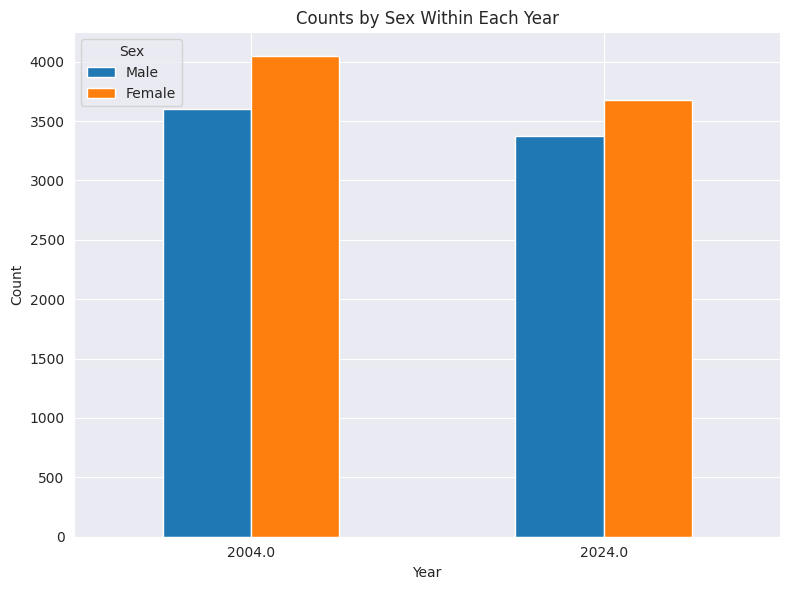

In [19]:
# Count occurrences of each gender (CH04) grouped by year (ANO4)
grouped = cleaned_2004_24.groupby(["ANO4", "CH04"]).size().unstack(fill_value=0)

# Rename columns for clarity
grouped.columns = ["Male", "Female"]

# Plot the gender composition as a bar chart
grouped.plot(kind="bar", figsize=(8, 6))
plt.title("Counts by Sex Within Each Year")  # Set the title
plt.ylabel("Count")  # Label the y-axis
plt.xlabel("Year")  # Label the x-axis
plt.xticks(rotation=0)  # Keep x-axis labels horizontal
plt.legend(title="Sex")  # Add a legend
plt.tight_layout()  # Adjust layout for better spacing
plt.show()


### Part 1, Question 2d

2d.	Create a correlation matrix for 2004 and 2024 with the following variables: CH04, CH06, CH07, CH08, ED LEVEL, STATE, CAT_INAC, IPCF . Use any of the commands available in this link or this link to graph the correlation matrix. Comment on the results.

In [20]:
''' Three major steps:
    Step 1 - return the rows of data for 2004 and 2024, and put them into separate dataframes
    Step 2 - Return ONLY the columns you have asked for, and place those in separate dataframes
    Step 3 - Run the correlation matrix'''

# Filter rows for 2004 and select specific columns for correlation
clean_2004 = cleaned_2004_24[cleaned_2004_24["ANO4"] == 2004]
clean_corr_cols_2004 = clean_2004[["CH04", "CH06", "CH07", "CH08", "NIVEL_ED", "ESTADO", "CAT_INAC", "IPCF"]]

# Filter rows for 2024 and select the same columns
clean_2024 = cleaned_2004_24[cleaned_2004_24["ANO4"] == 2024]
clean_corr_cols_2024 = clean_2024[["CH04", "CH06", "CH07", "CH08", "NIVEL_ED", "ESTADO", "CAT_INAC", "IPCF"]]

# Compute the correlation matrix for 2004
corr_2004 = clean_corr_cols_2004.corr()

# Compute the correlation matrix for 2024
corr_2024 = clean_corr_cols_2024.corr()


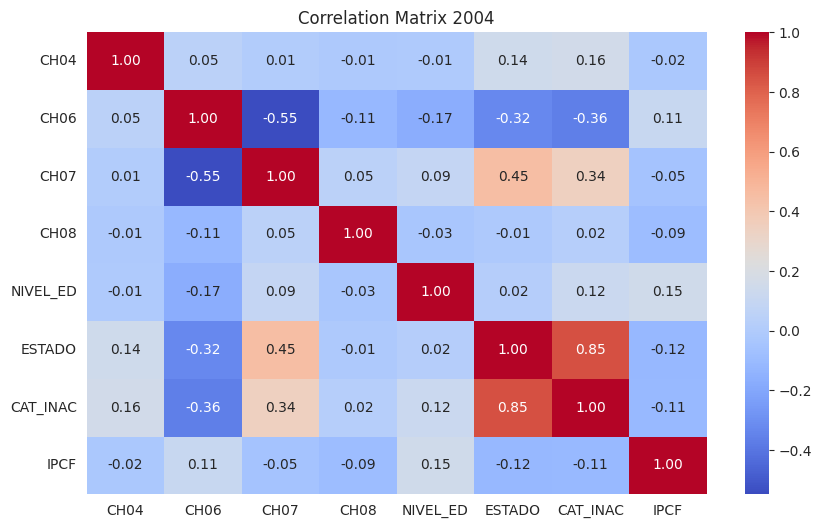

In [21]:
'''Using seaborn (sns) to plot the correlation matrix'''
# Plot the correlation matrix for 2004 using a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_2004, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Matrix 2004")  # Set the title
plt.show()

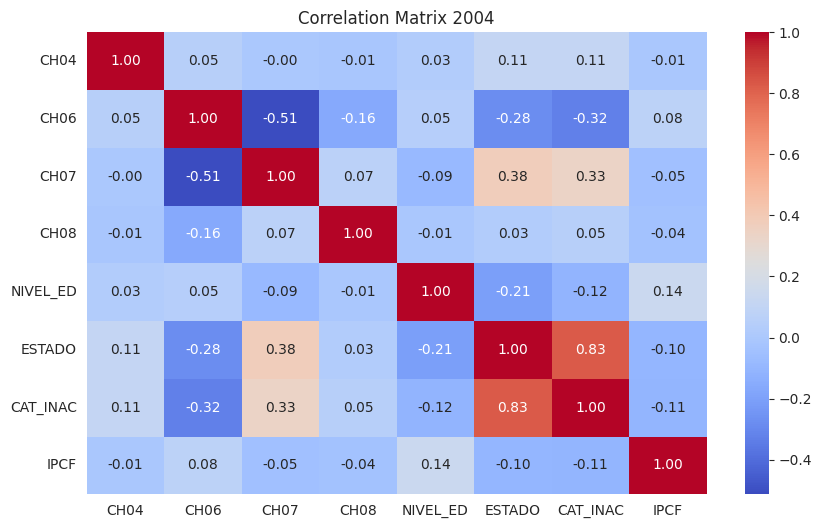

In [22]:
'''Using seaborn (sns) to plot the correlation matrix'''
# Plot the correlation matrix for 2024 using a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_2024, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Matrix 2024")  # Set the title
plt.show()

In [23]:
''' Check the difference between the matrices using euclidean distance.
    The euclidean distance between the two matrices demonstrates 
    that the values in each location of the matrix (row, column)
    are about 32.5% different from each other.  They are 0.65 from each
    other in raw distance, but the correlation is scaled between -1 and 1,
    a distance of 2 - that is the matrices cannot have a euclidean distance
    greater than 2. Dividing 0.65 by 2 therefore tells us they are 32% different.'''

corr_matrix_dist = np.linalg.norm(corr_2004 - corr_2024)/2 * (100)
print(corr_matrix_dist)

32.525589095049675


In [24]:
''' However, the second question is whether or not the differences between
    the matrices mean they are not part of the same group; in other words
    are they so different that they are dissimilar to each other.  For
    this we use the cosine similarity of the matrices.  A cosine similarity
    of 1 means the two matrices have an identical feature pattern, although
    the magnitudes of those features might differ; e.g. [1, 2, 3, 4] and  
    [2,4,6,8] have a cosine similarity of 1.  A cosine similarity of 0
    means that they are maximally dissimilar and share no feature patterns
    in common.'''
def cosine_similarity(a, b):
    """
    Compute the cosine similarity between two vectors or flattened matrices.

    Parameters:
    a (np.ndarray): First vector or matrix.
    b (np.ndarray): Second vector or matrix.

    Returns:
    float: Cosine similarity.
    """
    dot_product = np.dot(a, b)  # Dot product of the two vectors
    norm_a = np.linalg.norm(a)  # Magnitude of vector a
    norm_b = np.linalg.norm(b)  # Magnitude of vector b
    return dot_product / (norm_a * norm_b)

# Flatten the matrices (if they are matrices) and calculate cosine similarity
similarity = cosine_similarity(corr_2004.to_numpy().flatten(), corr_2024.to_numpy().flatten())
print("Cosine Similarity:", similarity)


''' So, given the similarity below, we can say that the two matrices share nearly identical feature patterns,
    but that the overall change from 2004 to 2024 is about 32.5%.  This confirms that the relationships BETWEEN the variables
    has remained stable over the years.  As a result the euclidean distance result is meaningful
    in the context of measurement because the variable relationships are the same. Put another way
    The differences in magnitude of 32.5% are real differences, not differences because something about
    the feature representations themselves has changed....Causal analysis is a whole different problem.'''

Cosine Similarity: 0.9815099445223846


' So, given the similarity below, we can say that the two matrices share nearly identical feature patterns,\n    but that the overall change from 2004 to 2024 is about 32.5% - causal analysis is a whole different problem.'

### Part 1, Question 2e
2e.	How many unemployed people are there in the sample? How many are inactive? What is the average family per capita income (IPCF) according to status (employed, unemployed, inactive)?

In [25]:
''' employed = 1
    unemployed = 2
    inactive = 3'''

# Group data by employment status (ESTADO) and compute count and average income (IPCF)
summary = cleaned_2004_24.groupby("ESTADO")["IPCF"].agg(
    count="size",      # Number of observations in each group
    avg_income="mean"  # Mean income in each group
).reset_index()

# Print the summary for relevant employment statuses (1, 2, 3 = employed, unemployed, inactive)
print(summary[1:4])


   ESTADO  count     avg_income
1       1   6303  106443.404820
2       2    839   31655.957950
3       3   5462   63863.080627


### Part 1, Question 3.

3. One of the major problems of the EPH is the growing number of households that do not report their income (see for example the following report ). How many people did not answer their activity status? Save as a separate database called answered the observations where they answered the question about their activity status ( STATUS ). Save the observations with STATUS=0 in a database under the name did not answer .

In [26]:
'''We created two databases called "norespondieron' and 'respondieron'''
norespondieron = cleaned_2004_24[cleaned_2004_24["ESTADO"] == 0]
respondieron = cleaned_2004_24[cleaned_2004_24["ESTADO"] != 0]
print(len(norespondieron), len(respondieron))


51 14647


### Part 1, Question 4.
Agreguen a la base "respondieron" una columna llamada PEA (Población Económicamente Activa) que tome 1 si están ocupados o 2 si estan desocupados en ESTADO. Realicen un gráfico de barras mostrando la composición por PEA para 2004 y 2024. Comenten los resultados.

In [27]:
respondieron['PEA'] = np.nan  # Initialize with NaN
respondieron.loc[respondieron['ESTADO'] == 1, 'PEA'] = 1  # Set to 1 where ESTADO is 1
respondieron.loc[respondieron['ESTADO'] == 2, 'PEA'] = 2 # Set to 2 where ESTADO is 2

/tmp/ipykernel_334916/711587451.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron['PEA'] = np.nan  # Initialize with NaN


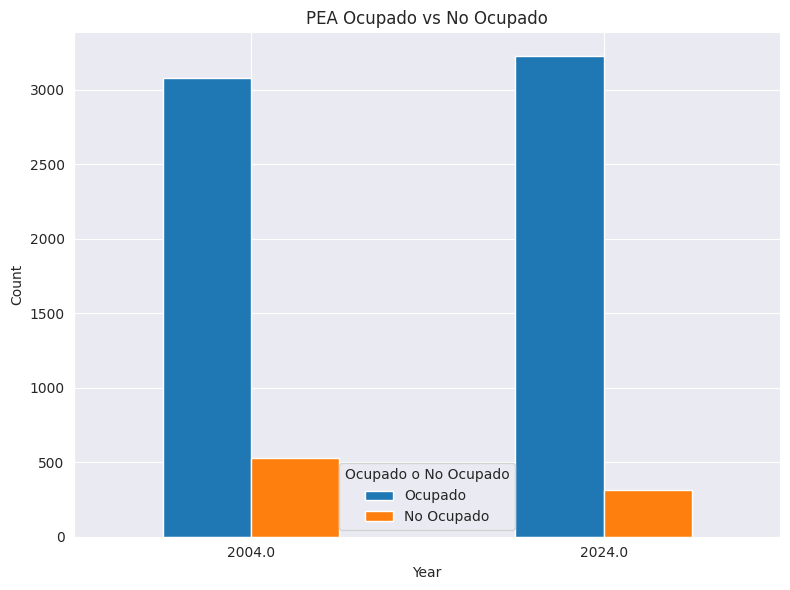

In [29]:
# Group data by year (ANO4) and PEA status, counting occurrences
grouped = respondieron.groupby(["ANO4", "PEA"]).size().unstack(fill_value=0)

# Rename columns for clarity
grouped.columns = ["Ocupado", "No Ocupado"]

# Plot the PEA composition as a bar chart
grouped.plot(kind="bar", figsize=(8, 6))
plt.title("PEA Ocupado vs No Ocupado")  # Set the title
plt.ylabel("Count")  # Label the y-axis
plt.xlabel("Year")  # Label the x-axis
plt.xticks(rotation=0)  # Keep x-axis labels horizontal
plt.legend(title="Ocupado o No Ocupado")  # Add a legend
plt.tight_layout()  # Adjust layout for better spacing
plt.show()


### Part 1, Question 5.
5.	Agreguen a la base respondieron una columna llamada PET (Población en Edad para Trabajar) que tome 1 si están la persona tiene entre 15 y 65 años cumplidos. Realicen un gráfico de barras mostrando la composición por PEA para 2004 y 2024. Comenten los resultados y compare PET con PEA.

In [30]:
# Add a column to indicate if the individual is in the working-age population (PET)
respondieron['PET'] = np.nan  # Initialize the column with NaN

# Assign PET = 1 for individuals aged 15–65 years
respondieron['PET'] = np.where(
    (respondieron['CH06'] >= 15) & (respondieron['CH06'] <= 65),  # Age condition
    1,  # Value if condition is met
    0   # Value if condition is not met
)


/tmp/ipykernel_334916/2695499990.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron['PET'] = np.nan  # Initialize with NaN
/tmp/ipykernel_334916/2695499990.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron['PET'] = np.where(


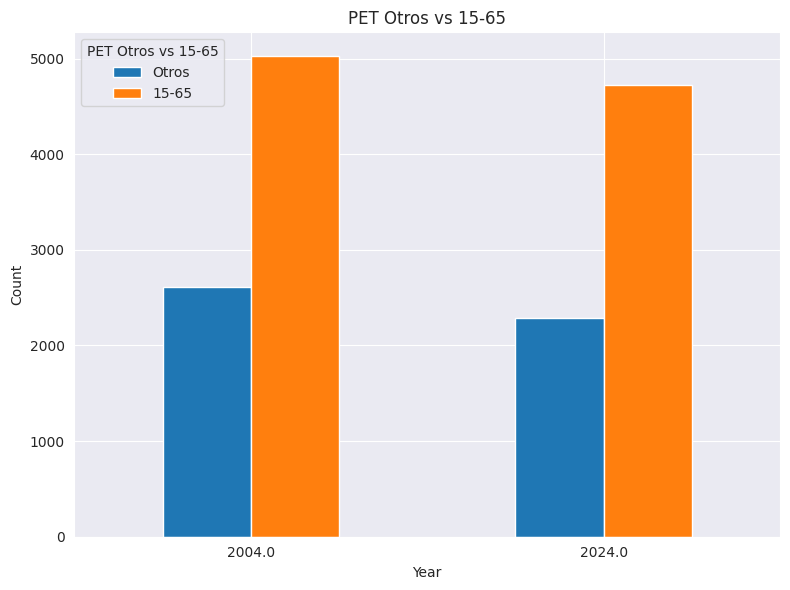

In [31]:
# Group data by year (ANO4) and PET status, counting occurrences
grouped = respondieron.groupby(["ANO4", "PET"]).size().unstack(fill_value=0)

# Rename columns for clarity
grouped.columns = ["Otros", "15-65"]

# Plot the PET composition as a bar chart
grouped.plot(kind="bar", figsize=(8, 6))
plt.title("PET Otros vs 15-65")  # Set the title
plt.ylabel("Count")  # Label the y-axis
plt.xlabel("Year")  # Label the x-axis
plt.xticks(rotation=0)  # Keep x-axis labels horizontal
plt.legend(title="PET Otros vs 15-65")  # Add a legend
plt.tight_layout()  # Adjust layout for better spacing
plt.show()


### Part 1, Question 6.
6.	Por ultimo, agreguen la base respondieron una columna llamada desocupado que tome 1 si esta desocupada. ¿Cuántas personas están desocupadas en 2004 vs 2024?

In [32]:
# Add a column to indicate if the individual is unemployed (DESOCUPADO)
respondieron["DESOCUPADO"] = np.nan  # Initialize the column with NaN

# Assign DESOCUPADO = 1 for unemployed individuals (ESTADO == 2)
respondieron.loc[respondieron['ESTADO'] == 2, 'DESOCUPADO'] = 1


/tmp/ipykernel_334916/2118716575.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron["DESOCUPADO"] = np.nan


In [33]:
respondieron.groupby(["ANO4", "DESOCUPADO"]).size().unstack(fill_value=0)

DESOCUPADO,1.0
ANO4,
2004.0,528
2024.0,311


# Part 2: Clasificacion

### Part 2, Question 1

1.	Para cada año, partan la base respondieron en una base de prueba (test) y una de entrenamiento (train) utilizando el comando train_test_split. La base de entrenamiento debe comprender el 70% de los datos, y la semilla a utilizar (random state instance) debe ser 101. Establezca a desocupado como su variable dependiente en la base de entrenamiento (vector y). El resto de las variables serán las variables independientes (matriz X). Recuerden agregar la columna de unos (1).


In [34]:
''' Steps:
    1. Add the bias term (column of ones)
    2. OHE non-numeric variables. 
    2. Split the cleaned dataframe into two based on year.
    3. Split the dataframes into train and test (70/30); ensure randomization'''

respondieron["BIAS"] = 1
respondieron.isna().sum()
respondieron = respondieron.fillna("None")






/tmp/ipykernel_334916/3187300204.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron["BIAS"] = 1


In [35]:
# Perform one-hot encoding on categorical variables
respondieron_OHE = pd.get_dummies(respondieron)


In [36]:
# Separate the one-hot encoded data into 2004 and 2024 subsets
respondieron_2004_OHE = respondieron_OHE[respondieron_OHE["ANO4"] == 2004]
respondieron_2024_OHE = respondieron_OHE[respondieron_OHE["ANO4"] == 2024]

# Extract dependent variable (y) and independent variables (X) for 2004
y_2004 = respondieron_2004_OHE["DESOCUPADO_1.0"]
X_2004 = respondieron_2004_OHE.drop(["DESOCUPADO_1.0"], axis=1)

# Extract dependent variable (y) and independent variables (X) for 2024
y_2024 = respondieron_2024_OHE["DESOCUPADO_1.0"]
X_2024 = respondieron_2024_OHE.drop(["DESOCUPADO_1.0"], axis=1)


In [37]:
# Split 2004 data into training (70%) and testing (30%) sets
X_2004_train, X_2004_test, y_2004_train, y_2004_test = train_test_split(
    X_2004, y_2004, test_size=0.3, random_state=101
)

# Split 2024 data into training (70%) and testing (30%) sets
X_2024_train, X_2024_test, y_2024_train, y_2024_test = train_test_split(
    X_2024, y_2024, test_size=0.3, random_state=101
)

# Standardize the features for both years
scaler = StandardScaler()

# Apply scaling to the training and testing sets of 2004 data
X_2004_train = scaler.fit_transform(X_2004_train)
X_2004_test = scaler.transform(X_2004_test)

# Apply scaling to the training and testing sets of 2024 data
X_2024_train = scaler.fit_transform(X_2024_train)
X_2024_test = scaler.transform(X_2024_test)


### Part 2, Question 2

2.	Implementen los siguientes métodos reportando luego la matriz de confusión, la curva ROC, los valores de AUC y de Accuracy de cada uno:

•	Regresión logística

•	Análisis discriminante lineal

•	KNN con k=3

•	Naive Bayes


#### Regresion logistica

               Predicted Negative  Predicted Positive
True Negative                2132                   1
True Positive                   5                 154
Accuracy 2004: 0.997382
ROC AUC Score: 1.00


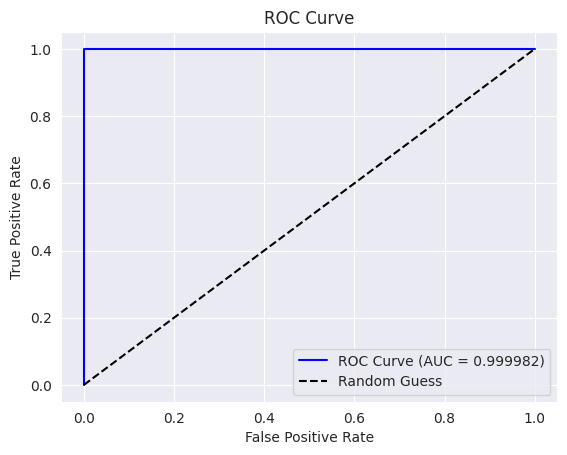

In [38]:
log_reg_2004 = LogisticRegression(max_iter = 50000, n_jobs = -1)  # Initialize a logistic regression model with:
# max_iter = 50000: Allowing up to 50,000 iterations to ensure convergence.
# n_jobs = -1: Using all available CPU cores for parallel computations.

log_reg_2004.fit(X_2004_train, y_2004_train)  # Train the logistic regression model using training features (X_2004_train) and labels (y_2004_train).

y_log_reg_pred_2004 = log_reg_2004.predict(X_2004_test)  # Generate binary predictions (0 or 1) on the test set (X_2004_test).

y_log_reg_pred_prob_2004 = log_reg_2004.predict_proba(X_2004_test)[:,1]  
# Compute probabilities of class 1 (unemployed) for each test sample.
# predict_proba returns probabilities for both classes; [:,1] extracts probabilities for class 1.

accuracy_2004 = accuracy_score(y_2004_test, y_log_reg_pred_2004)  
# Calculate accuracy as the proportion of correct predictions (True Positives + True Negatives / Total).

cm_log_reg_2004 = confusion_matrix(y_2004_test, y_log_reg_pred_2004)  
# Generate a confusion matrix to evaluate the model's classification performance:
# True Negatives, False Positives, False Negatives, and True Positives.

labels = ['True Negative', 'True Positive']  # Labels for rows (true values) in the confusion matrix.

cm_log_reg_df_2004 = pd.DataFrame(cm_log_reg_2004, index=['True Negative', 'True Positive'], columns=['Predicted Negative', 'Predicted Positive'])  
# Convert the confusion matrix into a pandas DataFrame with meaningful labels for rows and columns.

fpr, tpr, thresholds = roc_curve(y_2004_test, y_log_reg_pred_prob_2004)  
# Compute the False Positive Rate (fpr), True Positive Rate (tpr), and decision thresholds for plotting the ROC curve.

print(cm_log_reg_df_2004)  # Display the confusion matrix in a tabular format.

print(f"Accuracy 2004: {accuracy_2004:.6f}")  # Print the model's accuracy, formatted to six decimal places.

# Generate the ROC curve data
fpr, tpr, thresholds = roc_curve(y_2004_test, y_log_reg_pred_prob_2004)  
# Repeated computation of ROC values (this line is redundant but doesn't affect output).

roc_auc = roc_auc_score(y_2004_test, y_log_reg_pred_prob_2004)  
# Calculate the Area Under the ROC Curve (AUC) score.
# AUC evaluates the model's ability to distinguish between the two classes, with values between 0.5 (random guess) and 1.0 (perfect model).

print(f"ROC AUC Score: {roc_auc:.2f}")  # Print the AUC score, formatted to two decimal places.

# Plot the ROC curve
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.6f})", color="blue")  
# Plot the ROC curve (True Positive Rate vs. False Positive Rate) in blue.
# Label the curve with the AUC score for reference.

plt.plot([0, 1], [0, 1], "k--", label="Random Guess")  
# Plot a diagonal line (dashed, black) to represent a random-guess model for comparison.

plt.xlabel("False Positive Rate")  # Label the x-axis as "False Positive Rate".
plt.ylabel("True Positive Rate")  # Label the y-axis as "True Positive Rate".
plt.title("ROC Curve")  # Add a title to the plot.
plt.legend(loc="lower right")  # Add a legend in the lower-right corner of the plot.

plt.show()  # Display the plot.

'''based in the curve, there is no trade-off between the false and true positive rates. This model shows that we are close to the optimum of the prediction'''

               Predicted Negative  Predicted Positive
True Negative                1996                   0
True Positive                   6                 101
Accuracy 2024: 0.997147
ROC AUC Score: 1.00


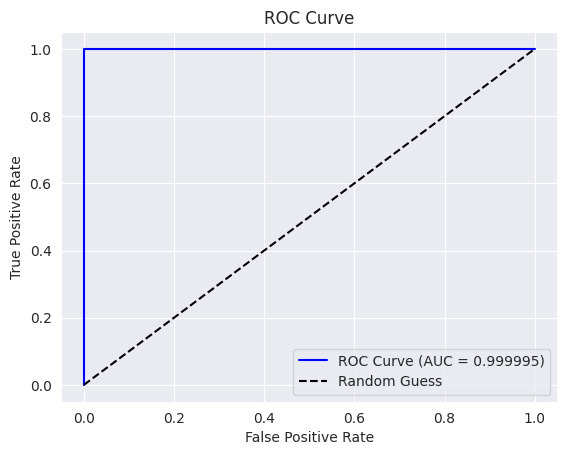

In [73]:
log_reg_2024 = LogisticRegression(max_iter = 200000, n_jobs = -1)  
# Initialize a logistic regression model with:
# max_iter = 200000: Allowing up to 200,000 iterations to ensure convergence.
# n_jobs = -1: Using all available CPU cores for parallel computations.

log_reg_2024.fit(X_2024_train, y_2024_train)  
# Train the logistic regression model using training features (X_2024_train) and labels (y_2024_train).

y_log_reg_pred_2024 = log_reg_2024.predict(X_2024_test)  
# Generate binary predictions (0 or 1) on the test set (X_2024_test).

y_log_reg_pred_prob_2024 = log_reg_2024.predict_proba(X_2024_test)[:,1]  
# Compute probabilities of class 1 (unemployed) for each test sample.
# predict_proba returns probabilities for both classes; [:,1] extracts probabilities for class 1.

accuracy_2024 = accuracy_score(y_2024_test, y_log_reg_pred_2024)  
# Calculate accuracy as the proportion of correct predictions (True Positives + True Negatives / Total).

cm_log_reg_2024 = confusion_matrix(y_2024_test, y_log_reg_pred_2024)  
# Generate a confusion matrix to evaluate the model's classification performance:
# True Negatives, False Positives, False Negatives, and True Positives.

labels = ['True Negative', 'True Positive']  # Labels for rows (true values) in the confusion matrix.

cm_log_reg_df_2024 = pd.DataFrame(cm_log_reg_2024, index=['True Negative', 'True Positive'], columns=['Predicted Negative', 'Predicted Positive'])  
# Convert the confusion matrix into a pandas DataFrame with meaningful labels for rows and columns.

print(cm_log_reg_df_2024)  # Display the confusion matrix in a tabular format.

fpr, tpr, thresholds = roc_curve(y_2024_test, y_log_reg_pred_prob_2024)  
# Compute the False Positive Rate (fpr), True Positive Rate (tpr), and decision thresholds for plotting the ROC curve.

print(f"Accuracy 2024: {accuracy_2024:.6f}")  
# Print the model's accuracy, formatted to six decimal places.

# Generate the ROC curve data
fpr, tpr, thresholds = roc_curve(y_2024_test, y_log_reg_pred_prob_2024)  
# Repeated computation of ROC values (this line is redundant but doesn't affect output).

roc_auc = roc_auc_score(y_2024_test, y_log_reg_pred_prob_2024)  
# Calculate the Area Under the ROC Curve (AUC) score.
# AUC evaluates the model's ability to distinguish between the two classes, with values between 0.5 (random guess) and 1.0 (perfect model).

print(f"ROC AUC Score: {roc_auc:.2f}")  
# Print the AUC score, formatted to two decimal places.

# Plot the ROC curve
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.6f})", color="blue")  
# Plot the ROC curve (True Positive Rate vs. False Positive Rate) in blue.
# Label the curve with the AUC score for reference.

plt.plot([0, 1], [0, 1], "k--", label="Random Guess")  
# Plot a diagonal line (dashed, black) to represent a random-guess model for comparison.

plt.xlabel("False Positive Rate")  # Label the x-axis as "False Positive Rate".
plt.ylabel("True Positive Rate")  # Label the y-axis as "True Positive Rate".
plt.title("ROC Curve")  # Add a title to the plot.
plt.legend(loc="lower right")  # Add a legend in the lower-right corner of the plot.

plt.show()  # Display the plot.


#### Linear Discriminator

Accuracy (LDA) 2004: 1.000000
               Predicted Negative  Predicted Positive
True Negative                2133                   0
True Positive                   0                 159
ROC AUC Score (LDA): 1.000000


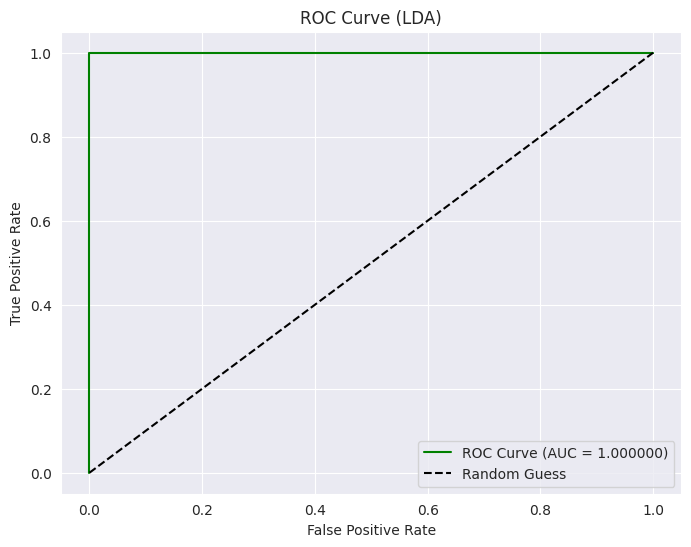

In [40]:
lda_2004 = LinearDiscriminantAnalysis()  # Initialize LDA model.

lda_2004.fit(X_2004_train, y_2004_train)  # Train LDA on training dataset.

y_lda_pred_2004 = lda_2004.predict(X_2004_test)  # Predict class labels for the test set.
y_lda_pred_prob_2004 = lda_2004.predict_proba(X_2004_test)[:, 1]  # Extract probabilities for class 1 (unemployed).

accuracy_lda_2004 = accuracy_score(y_2004_test, y_lda_pred_2004)  # Calculate accuracy score.
print(f"Accuracy (LDA) 2004: {accuracy_lda_2004:.6f}")  # Print accuracy to six decimal places.

cm_lda_2004 = confusion_matrix(y_2004_test, y_lda_pred_2004)  # Generate confusion matrix.
cm_lda_df_2004 = pd.DataFrame(cm_lda_2004, index=['True Negative', 'True Positive'], columns=['Predicted Negative', 'Predicted Positive'])  # Format confusion matrix with labels.
print(cm_lda_df_2004)  # Display the confusion matrix.

fpr_lda, tpr_lda, thresholds_lda = roc_curve(y_2004_test, y_lda_pred_prob_2004)  # Compute FPR, TPR, and thresholds for ROC.

roc_auc_lda = roc_auc_score(y_2004_test, y_lda_pred_prob_2004)  # Calculate AUC score.
print(f"ROC AUC Score (LDA): {roc_auc_lda:.6f}")  # Print AUC score.

plt.figure(figsize=(8, 6))  # Initialize figure with specified size.
plt.plot(fpr_lda, tpr_lda, label=f"ROC Curve (AUC = {roc_auc_lda:.6f})", color="green")  # Plot ROC curve with AUC label.
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")  # Plot diagonal line for random classifier.

plt.xlabel("False Positive Rate")  # Label x-axis.
plt.ylabel("True Positive Rate")  # Label y-axis.
plt.title("ROC Curve (LDA)")  # Add title to the plot.
plt.legend(loc="lower right")  # Add legend to lower-right corner.
plt.show()  # Display the plot.


Accuracy (LDA) 2024: 1.000000
               Predicted Negative  Predicted Positive
True Negative                1996                   0
True Positive                   0                 107
ROC AUC Score (LDA): 1.000000


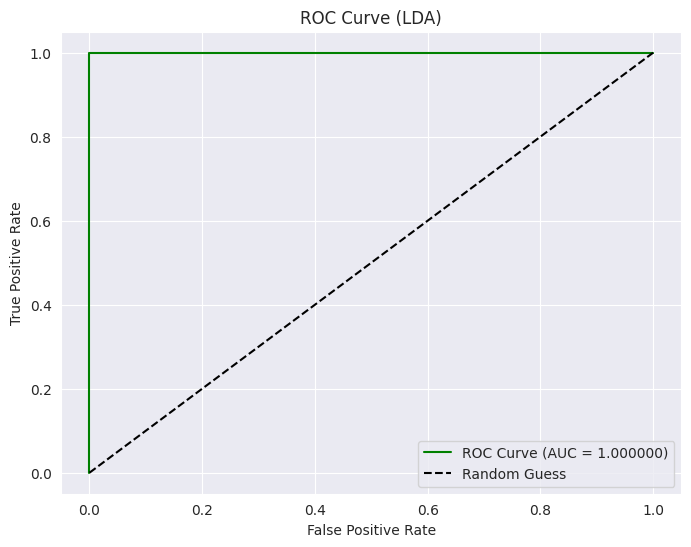

In [74]:
lda_2024 = LinearDiscriminantAnalysis()  # Initialize LDA model.

lda_2024.fit(X_2024_train, y_2024_train)  # Train LDA on 2024 training dataset.

y_lda_pred_2024 = lda_2024.predict(X_2024_test)  # Predict class labels for the 2024 test set.
y_lda_pred_prob_2024 = lda_2024.predict_proba(X_2024_test)[:, 1]  # Extract probabilities for class 1 (unemployed).

accuracy_lda_2024 = accuracy_score(y_2024_test, y_lda_pred_2024)  # Calculate accuracy score.
print(f"Accuracy (LDA) 2024: {accuracy_lda_2024:.6f}")  # Print accuracy for 2024 to six decimal places.

cm_lda_2024 = confusion_matrix(y_2024_test, y_lda_pred_2024)  # Generate confusion matrix for predictions.
cm_lda_df_2024 = pd.DataFrame(cm_lda_2024, index=['True Negative', 'True Positive'], columns=['Predicted Negative', 'Predicted Positive'])  # Format confusion matrix with labels.
print(cm_lda_df_2024)  # Display the confusion matrix.

fpr_lda, tpr_lda, thresholds_lda = roc_curve(y_2024_test, y_lda_pred_prob_2024)  # Compute FPR, TPR, and thresholds for the ROC curve.

roc_auc_lda = roc_auc_score(y_2024_test, y_lda_pred_prob_2024)  # Calculate AUC score for the ROC curve.
print(f"ROC AUC Score (LDA): {roc_auc_lda:.6f}")  # Print AUC score.

plt.figure(figsize=(8, 6))  # Initialize a figure with specified size.
plt.plot(fpr_lda, tpr_lda, label=f"ROC Curve (AUC = {roc_auc_lda:.6f})", color="green")  # Plot the ROC curve with AUC label.
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")  # Plot the diagonal random guess line.

plt.xlabel("False Positive Rate")  # Label x-axis.
plt.ylabel("True Positive Rate")  # Label y-axis.
plt.title("ROC Curve (LDA)")  # Add title to the plot.
plt.legend(loc="lower right")  # Add legend to the lower-right corner.
plt.show()  # Display the plot.


### KNN; k = 3

Accuracy (KNN, k=3) 2004: 0.947208
               Predicted Negative  Predicted Positive
True Negative                2116                  17
True Positive                 104                  55
ROC AUC Score (KNN, k=3): 0.796814


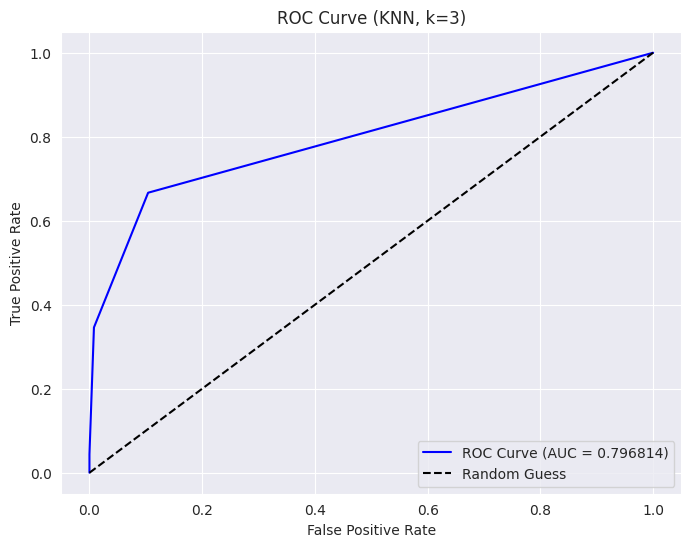

In [75]:
knn_2004 = KNeighborsClassifier(n_neighbors=3)  # Initialize KNN classifier with k=3.
knn_2004.fit(X_2004_train, y_2004_train)  # Train KNN on the 2004 training dataset.

y_knn_pred_2004 = knn_2004.predict(X_2004_test)  # Predict class labels for the 2004 test dataset.
y_knn_pred_prob_2004 = knn_2004.predict_proba(X_2004_test)[:, 1]  # Extract probabilities for class 1 (unemployed).

accuracy_knn_2004 = accuracy_score(y_2004_test, y_knn_pred_2004)  # Calculate accuracy score.
print(f"Accuracy (KNN, k=3) 2004: {accuracy_knn_2004:.6f}")  # Print accuracy to six decimal places.

cm_knn_2004 = confusion_matrix(y_2004_test, y_knn_pred_2004)  # Generate confusion matrix for KNN predictions.
cm_knn_df_2004 = pd.DataFrame(cm_knn_2004, index=['True Negative', 'True Positive'], columns=['Predicted Negative', 'Predicted Positive'])  # Format confusion matrix with labels.
print(cm_knn_df_2004)  # Display the confusion matrix.

fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_2004_test, y_knn_pred_prob_2004)  # Compute FPR, TPR, and thresholds for the ROC curve.

roc_auc_knn = roc_auc_score(y_2004_test, y_knn_pred_prob_2004)  # Calculate AUC score for the ROC curve.
print(f"ROC AUC Score (KNN, k=3): {roc_auc_knn:.6f}")  # Print AUC score to six decimal places.

plt.figure(figsize=(8, 6))  # Initialize a figure with specified size.
plt.plot(fpr_knn, tpr_knn, label=f"ROC Curve (AUC = {roc_auc_knn:.6f})", color="blue")  # Plot the ROC curve with AUC label.
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")  # Plot the diagonal random guess line.

plt.xlabel("False Positive Rate")  # Label x-axis.
plt.ylabel("True Positive Rate")  # Label y-axis.
plt.title("ROC Curve (KNN, k=3)")  # Add title to the plot.
plt.legend(loc="lower right")  # Add legend to the lower-right corner.
plt.show()  # Display the plot.


Accuracy (KNN, k=3) 2024: 0.966239
               Predicted Negative  Predicted Positive
True Negative                1991                   5
True Positive                  66                  41
ROC AUC Score (KNN, k=3): 0.823743


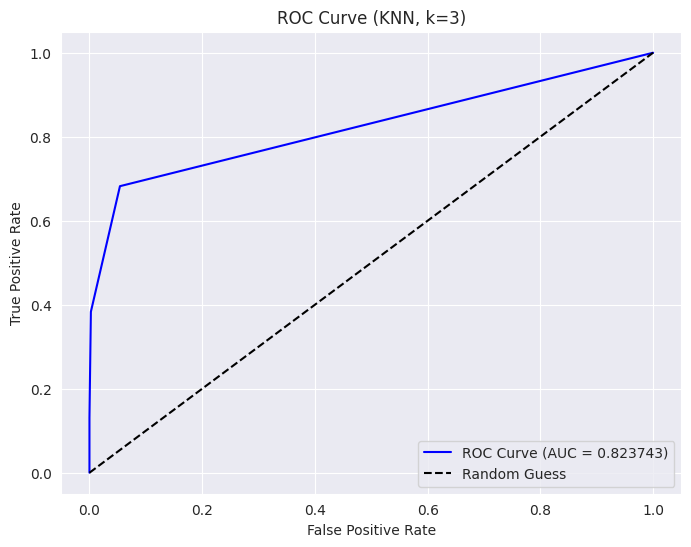

In [76]:
knn_2024 = KNeighborsClassifier(n_neighbors=3)  # Initialize KNN classifier with k=3.
knn_2024.fit(X_2024_train, y_2024_train)  # Train KNN on the 2024 training dataset.

y_knn_pred_2024 = knn_2024.predict(X_2024_test)  # Predict class labels for the 2024 test dataset.
y_knn_pred_prob_2024 = knn_2024.predict_proba(X_2024_test)[:, 1]  # Extract probabilities for class 1 (unemployed).

accuracy_knn_2024 = accuracy_score(y_2024_test, y_knn_pred_2024)  # Calculate accuracy score.
print(f"Accuracy (KNN, k=3) 2024: {accuracy_knn_2024:.6f}")  # Print accuracy to six decimal places.

cm_knn_2024 = confusion_matrix(y_2024_test, y_knn_pred_2024)  # Generate confusion matrix for KNN predictions.
cm_knn_df_2024 = pd.DataFrame(cm_knn_2024, index=['True Negative', 'True Positive'], columns=['Predicted Negative', 'Predicted Positive'])  # Format confusion matrix with labels.
print(cm_knn_df_2024)  # Display the confusion matrix.

fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_2024_test, y_knn_pred_prob_2024)  # Compute FPR, TPR, and thresholds for the ROC curve.

roc_auc_knn = roc_auc_score(y_2024_test, y_knn_pred_prob_2024)  # Calculate AUC score for the ROC curve.
print(f"ROC AUC Score (KNN, k=3): {roc_auc_knn:.6f}")  # Print AUC score to six decimal places.

plt.figure(figsize=(8, 6))  # Initialize a figure with specified size.
plt.plot(fpr_knn, tpr_knn, label=f"ROC Curve (AUC = {roc_auc_knn:.6f})", color="blue")  # Plot the ROC curve with AUC label.
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")  # Plot the diagonal random guess line.

plt.xlabel("False Positive Rate")  # Label x-axis.
plt.ylabel("True Positive Rate")  # Label y-axis.
plt.title("ROC Curve (KNN, k=3)")  # Add title to the plot.
plt.legend(loc="lower right")  # Add legend to the lower-right corner.
plt.show()  # Display the plot.


#### Naive Bayes; Gaussian (Note - this is NOT a good dataset for Gaussian.  Way too many categorical features and colinearities)

Accuracy (Naive Bayes) 2004: 0.935864
               Predicted Negative  Predicted Positive
True Negative                2092                  41
True Positive                 106                  53
ROC AUC Score (Naive Bayes): 0.657056


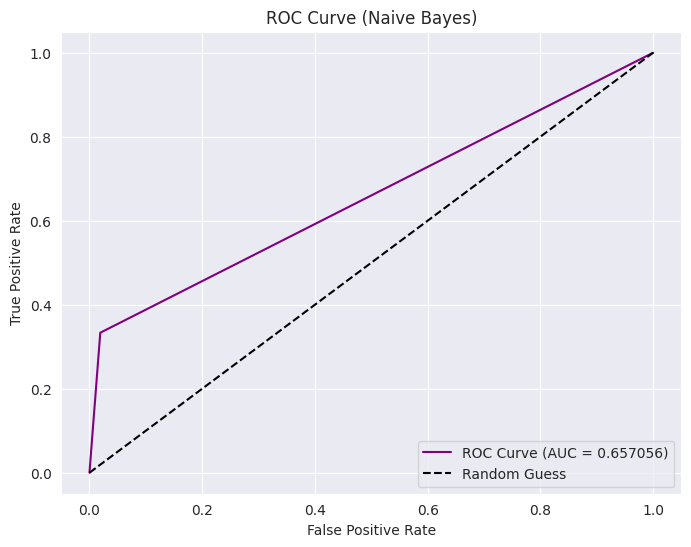

In [44]:
nb_2004 = GaussianNB()  # Initialize the Gaussian Naive Bayes classifier.
nb_2004.fit(X_2004_train, y_2004_train)  # Train the Naive Bayes model using the 2004 training dataset.

y_nb_pred_2004 = nb_2004.predict(X_2004_test)  # Predict class labels (binary) for the 2004 test dataset.
y_nb_pred_prob_2004 = nb_2004.predict_proba(X_2004_test)[:, 1]  # Extract probabilities for class 1 (unemployed).

accuracy_nb_2004 = accuracy_score(y_2004_test, y_nb_pred_2004)  # Calculate accuracy of the predictions.
print(f"Accuracy (Naive Bayes) 2004: {accuracy_nb_2004:.6f}")  # Print accuracy to six decimal places.

cm_nb_2004 = confusion_matrix(y_2004_test, y_nb_pred_2004)  # Generate confusion matrix for Naive Bayes predictions.
cm_nb_df_2004 = pd.DataFrame(cm_nb_2004, index=['True Negative', 'True Positive'], columns=['Predicted Negative', 'Predicted Positive'])  # Format confusion matrix with appropriate labels.
print(cm_nb_df_2004)  # Display the confusion matrix.

fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_2004_test, y_nb_pred_prob_2004)  # Compute FPR, TPR, and thresholds for the ROC curve.

roc_auc_nb = roc_auc_score(y_2004_test, y_nb_pred_prob_2004)  # Calculate AUC score for the ROC curve.
print(f"ROC AUC Score (Naive Bayes): {roc_auc_nb:.6f}")  # Print AUC score to six decimal places.

plt.figure(figsize=(8, 6))  # Create a figure for the plot with specified size.
plt.plot(fpr_nb, tpr_nb, label=f"ROC Curve (AUC = {roc_auc_nb:.6f})", color="purple")  # Plot the ROC curve with AUC label.
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")  # Plot the diagonal line representing random guessing.

plt.xlabel("False Positive Rate")  # Label x-axis as False Positive Rate.
plt.ylabel("True Positive Rate")  # Label y-axis as True Positive Rate.
plt.title("ROC Curve (Naive Bayes)")  # Add title to the plot.
plt.legend(loc="lower right")  # Place legend in the lower-right corner.
plt.show()  # Display the ROC curve plot.


Accuracy (Naive Bayes) 2024: 0.948645
               Predicted Negative  Predicted Positive
True Negative                1966                  30
True Positive                  78                  29
ROC AUC Score (Naive Bayes): 0.627999


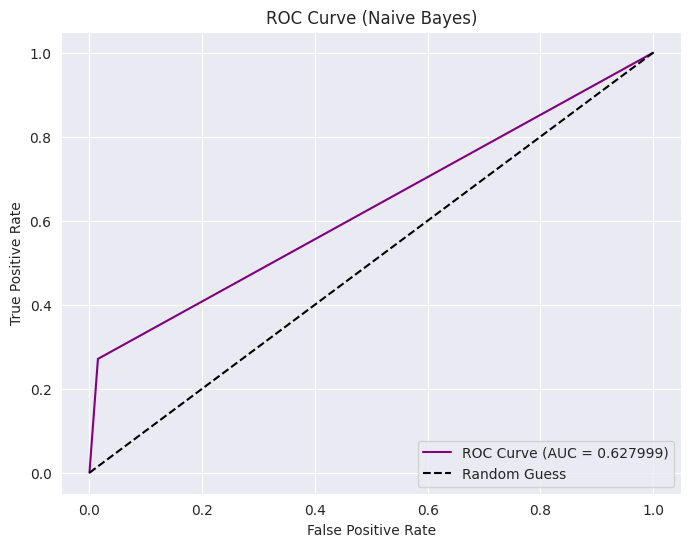

In [77]:
nb_2024 = GaussianNB()  # Initialize the Gaussian Naive Bayes classifier.
nb_2024.fit(X_2024_train, y_2024_train)  # Train the model using the 2024 training data.

y_nb_pred_2024 = nb_2024.predict(X_2024_test)  # Predict class labels (binary outcomes) for the 2024 test set.
y_nb_pred_prob_2024 = nb_2024.predict_proba(X_2024_test)[:, 1]  # Extract probabilities for the positive class (1).

accuracy_nb_2024 = accuracy_score(y_2024_test, y_nb_pred_2024)  # Calculate the accuracy of the predictions.
print(f"Accuracy (Naive Bayes) 2024: {accuracy_nb_2024:.6f}")  # Output the accuracy with six decimal precision.

cm_nb_2024 = confusion_matrix(y_2024_test, y_nb_pred_2024)  # Compute the confusion matrix.
cm_nb_df_2024 = pd.DataFrame(  # Format confusion matrix as a DataFrame with labeled rows and columns.
    cm_nb_2024, 
    index=['True Negative', 'True Positive'], 
    columns=['Predicted Negative', 'Predicted Positive']
)
print(cm_nb_df_2024)  # Display the formatted confusion matrix.

fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_2024_test, y_nb_pred_prob_2024)  # Generate data for the ROC curve.

roc_auc_nb = roc_auc_score(y_2024_test, y_nb_pred_prob_2024)  # Calculate the Area Under the Curve (AUC) score.
print(f"ROC AUC Score (Naive Bayes): {roc_auc_nb:.6f}")  # Print the AUC score with six decimal precision.

plt.figure(figsize=(8, 6))  # Initialize a new figure for the ROC curve with specific dimensions.
plt.plot(fpr_nb, tpr_nb, label=f"ROC Curve (AUC = {roc_auc_nb:.6f})", color="purple")  # Plot the ROC curve with a label.
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")  # Add a dashed line representing random guessing.

plt.xlabel("False Positive Rate")  # Label the x-axis.
plt.ylabel("True Positive Rate")  # Label the y-axis.
plt.title("ROC Curve (Naive Bayes)")  # Title the plot.
plt.legend(loc="lower right")  # Position the legend in the lower-right corner.
plt.show()  # Render th


### Part 2, Question 3
3.	Comente los resultados de 2004 versus 2024. ¿Cuál de los métodos predice mejor en cada año? Justifiquen detalladamente utilizando las medidas de precisión que conocen.


Linear Discriminator, without question

### Part 2, Question 4
4.	Con el método que seleccionaron, predigan qué personas son desocupadas dentro de la base norespondieron. ¿Qué proporción de las personas que no respondieron pudieron identificar como desocupadas?

In [78]:
''' The norespondieron dataframe includes both 2004 and 2024 data.  We therefore have to train an LDA containing
    both data sets at the same time, in order to be sure our model properly fits.  Because of this we have to 
    prepare the data the same way we did before, but this time on the entire cleaned dataframe, not divided
    by year.'''
cleaned_2004_24['PET'] = np.nan  # Initialize a new column 'PET' in the DataFrame with NaN values.

# Assign values to the 'PET' column:
# If the value in the 'CH06' column (age) is between 15 and 65 (inclusive), set 'PET' to 1.
# Otherwise, set 'PET' to 0.
cleaned_2004_24['PET'] = np.where(
    (cleaned_2004_24['CH06'] >= 15) & (cleaned_2004_24['CH06'] <= 65), 
    1, 
    0
)

cleaned_2004_24['PEA'] = np.nan  # Initialize a new column 'PEA' in the DataFrame with NaN values.

# Assign values to the 'PEA' column based on the 'ESTADO' column:
# If 'ESTADO' is 1 (employed), set 'PEA' to 1.
cleaned_2004_24.loc[cleaned_2004_24['ESTADO'] == 1, 'PEA'] = 1

# If 'ESTADO' is 2 (unemployed), set 'PEA' to 2.
cleaned_2004_24.loc[cleaned_2004_24['ESTADO'] == 2, 'PEA'] = 2

# Add a column 'DESOCUPADO' to indicate unemployment status:
# If 'ESTADO' is 2 (unemployed), set 'DESOCUPADO' to 1.
cleaned_2004_24.loc[cleaned_2004_24['ESTADO'] == 2, 'DESOCUPADO'] = 1

# Replace any remaining NaN values in the DataFrame with the string "None".
cleaned_2004_24 = cleaned_2004_24.fillna("None")

cleaned_2004_24["BIAS"] = 1  # Add a new column 'BIAS' with all values set to 1 (useful for regression models).

# Perform one-hot encoding on the DataFrame to convert categorical columns into dummy/indicator variables.
cleaned_2004_24_OHE = pd.get_dummies(cleaned_2004_24)


In [79]:
cleaned_2004_24_OHE.isna().sum().sum()

0

In [80]:
# Filter rows from the one-hot encoded DataFrame where 'ESTADO' equals 0 (did not respond)
# and store the result in a new DataFrame called `norespondieron_OHE`.
norespondieron_OHE = cleaned_2004_24_OHE[cleaned_2004_24_OHE["ESTADO"] == 0]

# Filter rows from the one-hot encoded DataFrame where 'ESTADO' does not equal 0 (responded)
# and store the result in a new DataFrame called `respondieron_OHE`.
respondieron_OHE = cleaned_2004_24_OHE[cleaned_2004_24_OHE["ESTADO"] != 0]

# Print the lengths (number of rows) of the `norespondieron` and `respondieron` DataFrames 
# to compare the sizes of these two groups.
print(len(norespondieron), len(respondieron))

# Count and print the total number of rows in the one-hot encoded DataFrame (`cleaned_2004_24_OHE`) 
# where 'ESTADO' equals 0. This provides the total count of individuals who did not res


51 14647


In [81]:
# Extract the dependent variable 'DESOCUPADO_1' (target) from the one-hot encoded DataFrame of those who responded
# and store it in `y_respondieron_OHE`. This column represents whether an individual is unemployed (1) or not (0).
y_respondieron_OHE = respondieron_OHE["DESOCUPADO_1"]

# Drop the dependent variable 'DESOCUPADO_1' from the DataFrame to create the feature matrix `X_respondieron_OHE`.
# This ensures only independent variables are used as input for training the model.
X_respondieron_OHE = respondieron_OHE.drop("DESOCUPADO_1", axis=1)

# One-hot encode the `ANO4` column (year) to convert it into separate binary columns for each year,
# and prefix these columns with "ANO4_" to indicate their origin.
ano4_OHE = pd.get_dummies(X_respondieron_OHE["ANO4"], prefix="ANO4")

# Remove the original `ANO4` column from `X_respondieron_OHE` after encoding to avoid redundancy.
X_respondieron_OHE = X_respondieron_OHE.drop("ANO4", axis=1)

# Concatenate the one-hot encoded year columns back to the feature matrix `X_respondieron_OHE`.
# This updates the feature matrix to include encoded year information.
X_respondieron_OHE = pd.concat([X_respondieron_OHE, ano4_OHE], axis=1)

# Split the feature matrix (`X_respondieron_OHE`) and the target variable (`y_respondieron_OHE`) into training and testing sets.
# Use 70% of the data for the test set and 30% for training. --- Let's see how little data we can get away with!
# Set the random seed to 101 for reproducibility.
X_train, X_test, y_train, y_test = train_test_split(X_respondieron_OHE, y_respondieron_OHE, test_size=0.7, random_state=101)

# Standardize the feature values in the training set using a `StandardScaler` to ensure all features have mean 0 and unit variance.
# This step helps in normalizing the scale of data for better model performance.
X_train = scaler.fit_transform(X_train)

# Apply the same transformation to the test set using the scaler fitted on the training data.
# This ensures the test data is scaled consistently with the training data.
X_test = scaler.transform(X_test)


Accuracy (LDA): 1.000000
               Predicted Negative  Predicted Positive
True Negative                9664                   0
True Positive                   0                 589
ROC AUC Score (LDA): 1.000000


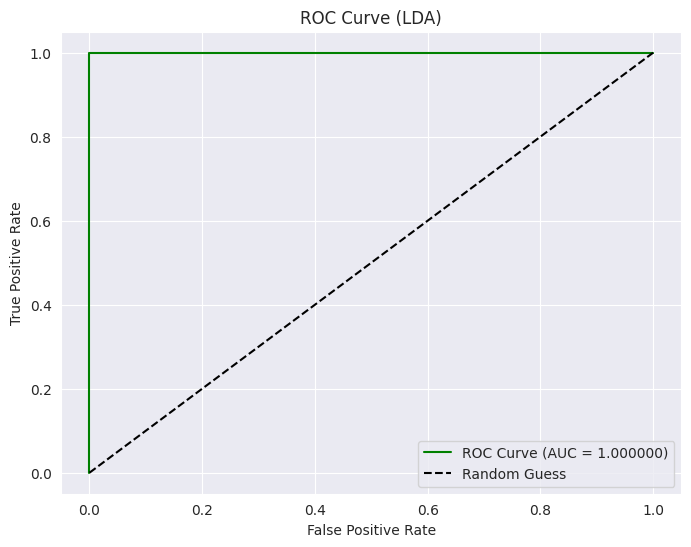

In [67]:
# Initialize the Linear Discriminant Analysis (LDA) classifier.
lda = LinearDiscriminantAnalysis()

# Fit the LDA model to the training data. The model learns to discriminate between the classes (unemployed vs. not unemployed).
lda.fit(X_train, y_train)

# Predict class labels (binary values 0 or 1) for the test data using the trained LDA model.
y_lda_pred = lda.predict(X_test)

# Predict probabilities for the positive class (1) for the test data.
# This gives the likelihood of each test sample belonging to the positive class.
y_lda_pred_prob = lda.predict_proba(X_test)[:, 1]

# Calculate the accuracy of the predictions by comparing the predicted class labels to the true labels.
accuracy_lda = accuracy_score(y_test, y_lda_pred)
print(f"Accuracy (LDA): {accuracy_lda:.6f}")

# Generate the confusion matrix to evaluate the performance of the classifier.
# The confusion matrix shows the counts of true negatives, true positives, false negatives, and false positives.
cm_lda = confusion_matrix(y_test, y_lda_pred)

# Convert the confusion matrix into a pandas DataFrame for better readability and labeling.
cm_lda_df = pd.DataFrame(cm_lda, index=['True Negative', 'True Positive'], 
                         columns=['Predicted Negative', 'Predicted Positive'])
print(cm_lda_df)

# Generate the False Positive Rate (FPR), True Positive Rate (TPR), and thresholds for the ROC curve.
# The ROC curve measures the trade-off between TPR and FPR at various threshold settings.
fpr_lda, tpr_lda, thresholds_lda = roc_curve(y_test, y_lda_pred_prob)

# Calculate the Area Under the Curve (AUC) for the ROC curve.
# The AUC score indicates the classifier's ability to distinguish between the classes.
roc_auc_lda = roc_auc_score(y_test, y_lda_pred_prob)
print(f"ROC AUC Score (LDA): {roc_auc_lda:.6f}")

# Plot the ROC curve for visual evaluation of the classifier's performance.
# A higher AUC indicates better performance.
plt.figure(figsize=(8, 6))  # Set the figure size for the plot.
plt.plot(fpr_lda, tpr_lda, label=f"ROC Curve (AUC = {roc_auc_lda:.6f})", color="green")  # Plot the ROC curve.
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")  # Plot a baseline for random guessing.
plt.xlabel("False Positive Rate")  # Label the x-axis.
plt.ylabel("True Positive Rate")  # Label the y-axis.
plt.title("ROC Curve (LDA)")  # Set the title of the plot.
plt.legend(loc="lower right")  # Add a legend to indicate what each curve represents.
plt.show()  # Display the plot.


In [83]:
# Drop the column "DESOCUPADO_1" from the dataset "norespondieron_OHE" as it is the target variable, 
# which should not be used as a predictor in the analysis.
X_norespondieron_OHE = norespondieron_OHE.drop("DESOCUPADO_1", axis=1)

# One-hot encode the "ANO4" (year) column, creating separate binary columns for each year in the dataset.
# The prefix "ANO4" is used to label these new columns clearly.
ano4_OHE = pd.get_dummies(X_norespondieron_OHE["ANO4"], prefix="ANO4")

# Drop the original "ANO4" column since it has now been replaced by its one-hot encoded representation.
X_norespondieron_OHE = X_norespondieron_OHE.drop("ANO4", axis=1)

# Concatenate the one-hot encoded year columns back into the dataset.
X_norespondieron_OHE = pd.concat([X_norespondieron_OHE, ano4_OHE], axis=1)

# Standardize the features using the previously fitted scaler to ensure the feature distribution is 
# consistent with the training data. This step is critical as the LDA model expects standardized inputs.
X_norespondieron_OHE = scaler.transform(X_norespondieron_OHE)

# Use the trained LDA model to predict the unemployment status for the "norespondieron_OHE" dataset.
# This assigns a prediction (0 or 1) for each individual based on the input features.
norespondieron_pred = lda.predict(X_norespondieron_OHE)

# Display the predictions (FALSE: not unemployed, TRUE: unemployed) for each individual in "norespondieron_OHE".


''' As we can see from the printout, most likely, all 51 Ns/Nr samples were actually employed'''
print(norespondieron_pred)


[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
